# Aprendizaje Multietiqueta de Patrones Geométricos en Objetos de Herencia Cultural
# Testing multilabel algorithms
## Seminario de Tesis II, Primavera 2022
### Master of Data Science. Universidad de Chile.
#### Prof. guía: Benjamín Bustos - Prof. coguía: Iván Sipirán
#### Autor: Matías Vergara

### Referencias:

Zhang, M. L., Li, Y. K., Liu, X. Y., & Geng, X. (2018). Binary relevance for multi-label learning: an overview. Frontiers of Computer Science, 12(2), 191–202.
https://doi.org/10.1007/s11704-017-7031-7

Kariuki C. Multi-Label Classification with Scikit-MultiLearn. 
https://www.section.io/engineering-education/multi-label-classification-with-scikit-multilearn/

## Montando Google Drive


In [1]:
# Mounting google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    root_dir = 'drive/MyDrive/TesisMV'
except:
    root_dir = '..'

In [2]:
import os
os.listdir(root_dir)

['.git',
 '.gitignore',
 '.idea',
 'actas',
 'entregables',
 'features',
 'graficos',
 'labels',
 'models',
 'notebooks',
 'outputs',
 'patterns',
 'presentaciones',
 'README.md',
 'requirements.txt',
 'tables']

## Selección de dataset y modelos

In [3]:
#modify only this cell
USE_RN50 = True
SUBCHAPTERS = False
ARCHITECTURE = 'resnet' 
DS_FLAGS = ['blur'] # blur para la proxima ejecucion 8 39 lun
              # 'ref': [invertX, invertY],
              # 'rot': [rotate90, rotate180, rotate270],
              # 'crop': [crop] * CROP_TIMES,
              # 'blur': [blur],
              # 'emboss': [emboss],
              # 'randaug': [randaug],
              # 'rain': [rain],
              # 'elastic': [elastic]
CROP_TIMES = 1
RANDOM_TIMES = 1
ELASTIC_TIMES = 1
NUM_LABELS = 26

In [4]:
# This cells builds the data_flags variable, that will be used
# to map the requested data treatment to folders
MAP_TIMES = {'crop': CROP_TIMES,
         'randaug': RANDOM_TIMES,
         'elastic': ELASTIC_TIMES,
}

DS_FLAGS = sorted(DS_FLAGS)
data_flags = '_'.join(DS_FLAGS) if len(DS_FLAGS) > 0 else 'base'
MULTIPLE_TRANSF = ['crop', 'randaug', 'elastic']
COPY_FLAGS = DS_FLAGS.copy()

for t in MULTIPLE_TRANSF:
    if t in DS_FLAGS:
        COPY_FLAGS.remove(t)
        COPY_FLAGS.append(t + str(MAP_TIMES[t]))
        data_flags = '_'.join(COPY_FLAGS)

subchapter_str = 'subchapters' if SUBCHAPTERS else ''
patterns_path = os.path.join(root_dir, 'patterns', subchapter_str, data_flags)
labels_path = os.path.join(root_dir, 'labels', subchapter_str + data_flags)
data_flags = f'resnet50_{data_flags}' if USE_RN50 else f'resnet18_{data_flags}'
features_path = os.path.join(root_dir, 'features', ARCHITECTURE, subchapter_str + data_flags)

#rn = 18
#ep = 65
#labels_path = folder_path + 'labels/' +  subchapter_str + data_flags + "/"
#data_flags = f'resnet50_{data_flags}_e{ep}' if USE_RN50 else f'resnet18_{data_flags}_e{ep}'
#features_path = folder_path + f"features/resnet{rn}_blur_each5/resnet{rn}_blur_e{ep}/"

print(features_path)
print(labels_path)
if not (os.path.isdir(features_path) and os.path.isdir(labels_path)):
    raise FileNotFoundError("No existen directorios de datos para el conjunto de flags seleccionado. Verifique que el dataset exista y, de lo contrario, llame a Split and Augmentation {}".format(
        (features_path, labels_path)))
print("Features set encontrado en {}".format(features_path))
print("Labels set encontrado en {}".format(labels_path))

#../features/resnet/resnet50_base/
#../labels/base/
#Features set encontrado en ../features/resnet/resnet50_base/
#Labels set encontrado en ../labels/base/

..\features\resnet\resnet50_base
..\labels\base
Features set encontrado en ..\features\resnet\resnet50_base
Labels set encontrado en ..\labels\base


In [5]:
train_filename = "augmented_train_df.json"
val_filename = "val_df.json"
test_filename = "test_df.json"

# Imports

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# Data treatment
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
import pickle

# Base classifiers
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score,hamming_loss, accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree

# Multilabel classifiers - Problem Transformation
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.ensemble import RakelD

# Multilabel classifiers - Algorithm Adaptation
from skmultilearn.adapt import BRkNNaClassifier
from skmultilearn.adapt import MLkNN
from skmultilearn.adapt import MLTSVM

# Metrics
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Procesamiento

In [7]:
features_train = pd.read_json(os.path.join(features_path, train_filename), orient='index').sort_index()
features_val = pd.read_json(os.path.join(features_path, val_filename), orient='index').sort_index()
features_test = pd.read_json(os.path.join(features_path, test_filename), orient='index').sort_index()

In [8]:
features_train

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
10a,0.220067,0.192842,0.230825,0.030218,0.096193,0.003017,0.056004,0.008634,0.103588,0.044708,...,0.239739,0.009333,0.134025,0.021282,0.064552,0.085574,0.073898,0.001953,0.121407,0.000000
10c,0.299684,0.205679,0.209356,0.100046,0.231695,0.010343,0.085307,0.059835,0.080415,0.020939,...,0.172179,0.069838,0.180563,0.033630,0.004924,0.061860,0.019382,0.033054,0.126834,0.028692
10d,0.270987,0.266924,0.061249,0.060208,0.235613,0.061621,0.070450,0.170796,0.071693,0.012005,...,0.058542,0.167929,0.165272,0.025749,0.001131,0.102660,0.013620,0.010305,0.108796,0.001071
10e,0.199509,0.294608,0.002447,0.088599,0.225461,0.131101,0.032750,0.138863,0.006781,0.000518,...,0.001919,0.100851,0.242753,0.028078,0.000662,0.063491,0.018281,0.015822,0.253149,0.000000
11a,0.273982,0.282333,0.032810,0.020401,0.038270,0.494274,0.029916,0.213418,0.025561,0.002748,...,0.006390,0.144122,0.009766,0.001530,0.000000,0.018667,0.094121,0.001674,0.340465,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96i,0.071190,0.088913,0.030630,0.017437,0.175513,0.006621,0.158218,0.000796,0.337129,0.101432,...,0.058232,0.006009,0.226061,0.017694,0.014825,0.054114,0.011399,0.000019,0.048853,0.000000
9a,0.500378,0.172919,0.978929,0.177229,0.197529,0.022774,0.131688,0.112513,0.095020,0.043275,...,0.766178,0.078866,0.262157,0.010490,0.012799,0.013864,0.030137,0.045483,0.527473,0.030071
9b,0.311907,0.122832,0.639037,0.084956,0.116858,0.001267,0.110946,0.032009,0.076971,0.010310,...,0.493930,0.049394,0.257918,0.004122,0.009260,0.007448,0.021136,0.009069,0.360306,0.008532
9c,0.380951,0.144732,0.787097,0.082002,0.104264,0.000000,0.095917,0.067211,0.057363,0.006513,...,0.535690,0.075754,0.165313,0.008245,0.033935,0.026949,0.063833,0.011848,0.395545,0.011779


In [9]:
features_val

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
12b,0.158649,0.343032,0.011104,0.002430,0.050546,0.000000,0.058953,0.362906,0.094652,0.019605,...,0.000092,0.304369,0.012839,0.002110,0.006219,0.122101,0.002222,0.000000,0.000000,0.000000
16f,0.146535,0.239076,0.049587,0.037750,0.124812,0.008113,0.036737,0.311976,0.048816,0.274058,...,0.016021,0.337968,0.032002,0.012320,0.048455,0.148350,0.024907,0.002994,0.000000,0.000000
16g,0.235887,0.166756,0.195317,0.084966,0.062483,0.003645,0.021952,0.201333,0.101995,0.123237,...,0.092556,0.229966,0.046881,0.005610,0.062429,0.075281,0.067494,0.004765,0.034680,0.000000
16m,0.298592,0.266534,0.194660,0.003221,0.044562,0.009384,0.009978,0.302399,0.018135,0.299909,...,0.063842,0.473962,0.009200,0.005088,0.030432,0.090868,0.016342,0.000000,0.012245,0.000000
17f,0.149026,0.183393,0.174828,0.097219,0.103264,0.004942,0.056811,0.174168,0.093136,0.144001,...,0.105412,0.203955,0.078905,0.001410,0.041037,0.067695,0.022213,0.034517,0.055417,0.031279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8e,0.183095,0.166033,0.231021,0.026943,0.010089,0.000087,0.012954,0.066893,0.022720,0.004003,...,0.117906,0.140854,0.155797,0.003042,0.046085,0.038281,0.057525,0.003491,0.233773,0.006070
91d,0.061823,0.068391,0.042061,0.116979,0.082585,0.601594,0.070860,0.053904,0.153675,0.097762,...,0.066492,0.055662,0.254246,0.013068,0.000537,0.032518,0.033173,0.112231,0.406606,0.086627
91h,0.185839,0.162354,0.306592,0.251026,0.230712,0.115108,0.066124,0.083007,0.121784,0.011110,...,0.304009,0.136232,0.411708,0.011924,0.002107,0.008212,0.063833,0.129474,0.520172,0.061925
95c,0.077586,0.105960,0.149050,0.066187,0.097664,0.019954,0.135751,0.041443,0.239777,0.044309,...,0.189260,0.045304,0.281287,0.028272,0.015453,0.052536,0.011363,0.047959,0.158877,0.042215


In [10]:
features_test

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
10b,0.074087,0.121114,0.132370,0.192546,0.008310,0.000000,0.079788,0.081601,0.162774,0.020339,...,0.159391,0.125147,0.416378,0.023475,0.000000,0.062729,0.008641,0.057672,0.190298,0.005672
11f,0.337709,0.414555,0.010937,0.046435,0.089350,0.100099,0.034077,0.286781,0.046609,0.027738,...,0.000369,0.191202,0.018856,0.008048,0.008043,0.031194,0.007089,0.001637,0.076802,0.000261
11k,0.128587,0.154116,0.022376,0.044917,0.035852,0.000622,0.014268,0.162960,0.077078,0.002161,...,0.010638,0.209407,0.069511,0.013787,0.000000,0.014390,0.029533,0.003718,0.219806,0.005807
12f,0.165577,0.267578,0.019211,0.010629,0.049284,0.075987,0.005297,0.223560,0.041279,0.015237,...,0.003023,0.164587,0.001058,0.001497,0.000000,0.080796,0.035298,0.000000,0.045881,0.000000
13c,0.320173,0.247374,0.007655,0.008800,0.059929,0.000016,0.052068,0.380871,0.109866,0.002040,...,0.000000,0.259275,0.001971,0.002619,0.000083,0.024916,0.013072,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94e,0.086579,0.125873,0.115031,0.060350,0.040235,0.015596,0.073849,0.049951,0.129612,0.015584,...,0.089076,0.067002,0.189135,0.007484,0.030101,0.029532,0.031096,0.012814,0.109269,0.013703
95l,0.041787,0.079226,0.058806,0.000765,0.050390,0.054277,0.076316,0.040558,0.252204,0.153073,...,0.095333,0.128200,0.140220,0.009222,0.017572,0.022397,0.012338,0.017417,0.105943,0.013524
96b,0.166240,0.155920,0.061952,0.013323,0.056883,0.000333,0.061204,0.028246,0.125493,0.032440,...,0.076224,0.040813,0.174878,0.003576,0.024637,0.024442,0.018224,0.005083,0.085142,0.010748
96c,0.243975,0.183229,0.309330,0.162092,0.253812,0.002771,0.191209,0.058836,0.256095,0.058465,...,0.292584,0.076721,0.437672,0.026018,0.002711,0.028479,0.018053,0.081014,0.189607,0.047730


In [11]:
features_test_val = pd.DataFrame.append(features_test, features_val)

In [12]:
labels_train = pd.read_json(os.path.join(labels_path, train_filename), orient='index').sort_index()
labels_val = pd.read_json(os.path.join(labels_path, val_filename), orient='index').sort_index()
labels_test = pd.read_json(os.path.join(labels_path, test_filename), orient='index').sort_index()

In [13]:
labels_train

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10a,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10d,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10e,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96i,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
9a,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9b,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9c,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
labels_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
12b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16g,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16m,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8e,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91d,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95c,0,0,1,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [15]:
labels_test

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10b,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11k,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13c,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94e,0,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
95l,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
96b,0,0,1,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
96c,0,0,1,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [16]:
labels_test_val = pd.DataFrame.append(labels_test, labels_val)
labels_test_val

,pendent,teardrop,horizontal,panel,group,vertical,bar,floating,enclosing,shorter,...,light,body,bird,striped,worm,angular,raised,head,bird-seed,long
10b,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11k,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13c,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8e,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91d,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91h,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95c,0,0,1,1,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [17]:
def filter_labels(labels_df, freq=25, number_labels = None):
  """Filters a label dataframe based on labels frequency (number of events)

    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  top_labels = None

  if not number_labels:
    filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > freq]
    top_labels = filtered_df.sum().sort_values(ascending=False)
    return top_labels, 0

  if number_labels:
      filtered_labels = labels_df.shape[1]
      pivot = 0
      while filtered_labels > number_labels:
        #print(filtered_labels, number_labels, pivot)
        filtered_df = labels_df.loc[:, labels_df.sum(axis=0) > pivot]
        top_labels = filtered_df.sum().sort_values(ascending=False)
        filtered_labels = filtered_df.shape[1]
        pivot += 1
      print("Aplicando threshold {} para trabajar con {} labels".format(pivot, len(top_labels.values)))
      return top_labels, pivot

def filter_dfs(df, top_labels_df):
  df = df[df.columns.intersection(top_labels_df.index)]
  return df

def combine_dfs(labels_df, top_labels_df, features_df):
  """Combine labels dataframe with features dataframe based on index (patterns names)
     keeping only the most frequent labels.

    Parameters:
    labels_df (DataFrame): dataframe of labels, with patterns name as index
    top_labels_df (DataFrame): a 1D dataframe with the name of the most freq. labels, as 
    the outcome of filter_labels() function 
    features_df (DataFrame): dataframe of features, with patterns name as index 

    Returns:
    DataFrame: combined labels + features dataframe, merged on index

  """
  assert len(labels_df) == len(features_df)
  labels_df = labels_df[labels_df.columns.intersection(top_labels_df.index)]
  final_df = pd.merge(labels_df,       
                      features_df,  
                      left_index=True, right_index=True)
  return final_df

def split_data(final_df, top_labels_df, test_size):
  """Splits the data in train and test. 
    
    Parameters:
    final_df (DataFrame): outcome of combine_dfs.
    top_labels_df (DataFrame): dataframe of most freq. labels. Necessary to 
    know at which column the labels (Y) ends and the features (X) starts  
    freq (int): threshold frequency. Labels with a lower value will be filtered. 
    test_size (float): proportion test/(test+train).

    Returns:
    (np.array, np.array, np.array, np.array): X train, X test, Y train, Y test

  """
  X = np.array(final_df.iloc[:, len(final_df):], dtype=float)
  Y = np.array(final_df.iloc[:, 0:len(final_df)], dtype=float)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,random_state=42)
  return X_train, X_test, Y_train, Y_test

In [18]:
train_labels = pd.read_json(os.path.join(labels_path, 'augmented_train_df.json'), orient='index')
if not os.path.isfile(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle')):
    print(f"Creando top_labels para {NUM_LABELS} labels")
    top_labels, _ = filter_labels(train_labels, number_labels = NUM_LABELS)
    save = input(f"Se creará un archivo nuevo para {len(top_labels)} labels. Desea continuar? (y/n)")
    if save == "y":
        with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'wb') as f:
            pickle.dump(top_labels, f)
        print(top_labels)
    else:
        raise Exception("No se logró cargar top_labels")
else:
    print(f"Usando top_labels previamente generados para {NUM_LABELS} labels")
    with open(os.path.join(root_dir, 'labels', f'top_{NUM_LABELS}L.pickle'), 'rb') as f:
        top_labels = pickle.load(f)
    print(top_labels)

Usando top_labels previamente generados para 26 labels
panel            289
horizontal       234
ornament         123
hatched          108
vertical         104
circle            80
metopal           77
filling           74
lozenge           64
enclosing         62
double            54
cross-hatched     51
triangle          49
line              42
chain             41
concentric        40
meander           40
bar               39
dotted            37
solid             35
dot               34
cross             31
outline           31
single            28
hook              27
floor             27
dtype: int64


# Data exploration

In [19]:
def get_unique_combinations(labels_df):
  """Returns the number of different combinations of labels in labels_df.

    Parameters:
    labels_df (DataFrame): dataframe of labels 

    Returns:
    int: number of unique labels combinations in labels_df
  """
  unique_combinations = len(labels_df.drop_duplicates())
  print("Number of unique labels combinations: " + str(unique_combinations))
  return unique_combinations

def get_label_metrics(labels_df):
  """Returns label cardinality and label density of a multilabel dataset.
     Label cardinality: average number of labels per entry 
     Label density: fraction of assigned labels over total num of labels,
                    averaged per entry
    Parameters:
    labels_df (DataFrame): dataframe of labels 
    freq (int): threshold frequency. Labels with a lower value will be filtered. 

    Returns:
    DataFrame: filtered labels dataframe

  """
  sum_labels = labels_df.sum(axis=1)
  total_labels = labels_df.shape[0]
  label_cardinality = 0
  for label in sum_labels:
    label_cardinality += label/total_labels
  label_density = label_cardinality/total_labels
  print("Label cardinality: {}".format(label_cardinality))
  print("Label density: {}".format(label_density))
  return(label_cardinality, label_density)

print("Exploring train set")
combinations = get_unique_combinations(labels_train)
metrics = get_label_metrics(labels_train)

Exploring train set
Number of unique labels combinations: 436
Label cardinality: 5.289667896678983
Label density: 0.009759534864721371


# Funciones auxiliares

In [20]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [33]:
def build_model(mlb_estimator, xtrain, ytrain, xtest, ytest, model=None):
    """Builds a multilabel estimator and runs it over a given train and test data,
       with an optional base classifier model.

    Parameters:
    mlb_estimator (mlb classifier): a PROBLEM_TRANSFORMATION or ALGORITHM_ADAPTATION 
                                    method from sklearn-multilabel
    xtrain, ytrain, xtest, ytest (np arrays): train and test data
    model (Base Estimator): optional, ignored if mlb_estimator is part of 
                            ALGORITHM_ADAPTATION methods. Base classifier to be 
                            used with the PROBLEM_TRANSFORMATION methods.

    Returns:
    (dict, np.array): dict with metrics (exact match, hamming loss and score) 
                      and array of predictions.
    """
    xtrain = sparse.csr_matrix(xtrain)
    ytrain = sparse.csr_matrix(ytrain)
    xtest = sparse.csr_matrix(xtest)
    ytest = sparse.csr_matrix(ytest)
    if model:
      clf = mlb_estimator(model)
    else:
      clf = mlb_estimator
    clf.fit(xtrain, ytrain)
    clf_predictions = clf.predict(xtest)
    clf_predictions = sparse.csr_matrix(clf_predictions)
    accuracy = accuracy_score(ytest,clf_predictions)
    recall = recall_score(ytest, clf_predictions, average='micro')
    precision = precision_score(ytest, clf_predictions, average='micro')
    f1 = f1_score(ytest, clf_predictions, average='micro')
    ham_loss = hamming_loss(ytest,clf_predictions)
    ham_score = hamming_score(ytest.toarray(), clf_predictions.toarray())
    result = {"accuracy":accuracy,
              "recall": recall,
              "precision": precision,
              "f1_score": f1,
              "hamming_loss": ham_loss, 
              "hamming_score":ham_score}
    return result, clf_predictions

In [34]:
# Plotting linemarks
ALREADY_RUN = False 

# This code has to be executed only once in order to have the same linemarks in 
# each figure
if not ALREADY_RUN:
  import random
  linemark = []
  MARKERS = ['.','+','v','x','*']
  LINE_STYLES = ['-','--','-.',':']

  for i in range(0, 20): 
    linestyle = LINE_STYLES[random.randint(0, len(LINE_STYLES)-1)]
    marker = MARKERS[random.randint(0, len(MARKERS)-1)]
    linemark.append (linestyle + marker)
  
  ALREADY_RUN = True

In [35]:
  def plot_results(x, acc = [], loss = [], score=[], label=[], title = "",
                 xlabel = "", ylabel = "", plot_emr=False, plot_hl=False, plot_hs=True):
    """plots accuracy, hamming loss and hamming score of multiple classifiers.
    
    Returns:
    DataFrame: filtered labels dataframe

    """
    assert len(acc) == len(loss) == len(label)
    if plot_emr:
        f_acc = plt.figure(1)
        f_acc.set_figheight(9)
        f_acc.set_figwidth(7)
        ax1 = f_acc.add_subplot(111)
        ax1.set_title(title + "\n Exact Match Ratio")
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel(ylabel)
        ax1.set_ylim(0, 1)
        for i in range(0, len(acc)):
          ax1.plot(x, acc[i],  linemark[i], label=label[i])
        ax1.legend()
        f_acc.show()
    if plot_hl:
        f_loss = plt.figure(2)
        f_loss.set_figheight(9)
        f_loss.set_figwidth(7)
        ax2 = f_loss.add_subplot(111)
        ax2.set_title(title  + "\n Hamming Loss")
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel(ylabel)
        for i in range(0, len(loss)):
          ax2.plot(x, loss[i], linemark[i], label=label[i])
        ax2.legend()
        f_loss.show()

    if plot_hs:
        f_score = plt.figure(3)
        f_score.set_figheight(9)
        f_score.set_figwidth(7)
        ax3 = f_score.add_subplot(111)
        ax3.set_title(title  + "\n Hamming Score")
        ax3.set_xlabel(xlabel)
        ax3.set_ylabel(ylabel)
        ax3.set_ylim(0, 1)
        #ax3.set_xlim(0, 100)
        for i in range(0, len(score)):
          ax3.plot(x, score[i], linemark[i], label=label[i])
        ax3.legend()
        f_score.show()

In [36]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):
    """
    Prints confusion matrix for multilabel classification.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title(class_label)

def plot_multiple_matrix(cfs_matrix, present_labels, nrows=5, ncols=5, figsize=(6,10), filename="results"):
  """
  Plots multiple confusion matrix

  Parameters:
  cfs_matrix (2D array): an array containing the multiple confusion matrix as
                         outcome of multilabel_confusion_matrix()
  present_labels (1D array): array of strings with name of labels, in the same
                             order as they are in cfs_matrix
  nrows, ncols, figsize: number of rows, columns and size of the plot
  
  """
  fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

  for axes, cfs_vals, label in zip(ax.flatten(), cfs_matrix, present_labels):
      print_confusion_matrix(cfs_vals, axes, label, ["N", "Y"])

  fig.tight_layout()
  plt.show()
  plt.savefig(filename + ".png")

# Benchmark


In [37]:
data_flags

'resnet50_base'

In [46]:
#MIN_FREQS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
#            26, 30, 34, 38, 40, 50, 60, 80, 100]
MIN_FREQS = [20, 26, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 
             160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]
#MIN_FREQS = [20, 30]
#MIN_FREQS = [20, 25, 30]
#labels_25, pivot = filter_labels(labels_train, 25, 25)
#freq_25 = labels_25.shape[0]
#MIN_FREQS = [int(pivot * 0.7), pivot, int(pivot * 1.3)]
#MIN_FREQS = [pivot]

TRANSF_METHODS = {"BR": BinaryRelevance, "LP": LabelPowerset,
                  "CC": ClassifierChain, "RakelD": RakelD}
mlknn = MLkNN(k=1, s=1)
mltsvm = MLTSVM(c_k=4)
brknna = BRkNNaClassifier(k=1)
ADAPT_METHODS = {"MLTSVM": mltsvm, "BRkNN": brknna, "MLkNN": mlknn}
BASE_CLASSIFIERS = {"LR": LogisticRegression(solver='lbfgs'),
                    "SVC": svm.SVC(), "DT": tree.DecisionTreeClassifier(), "GNB": GaussianNB()}
exp_exact_match = {}
exp_hscore = {}
exp_hloss = {}
exp_f1 = {}
exp_precision = {}
exp_recall = {}

for meth_name in TRANSF_METHODS.keys():
  for base_name in BASE_CLASSIFIERS.keys():
    exp_exact_match[meth_name + "_" + base_name] = []
    exp_hscore[meth_name + "_" + base_name] = []
    exp_hloss[meth_name + "_" + base_name] = []
    exp_f1[meth_name + "_" + base_name] = []
    exp_precision[meth_name + "_" + base_name] = []
    exp_recall[meth_name + "_" + base_name] = []
    
for meth_name in ADAPT_METHODS.keys():
  exp_exact_match[meth_name] = []
  exp_hscore[meth_name] = []
  exp_hloss[meth_name] = []
  exp_f1[meth_name] = []
  exp_precision[meth_name] = []
  exp_recall[meth_name] = []
    
for i in MIN_FREQS:
  print("Starting with i={}".format(i))

  # Dataset creation
  top_labels_i, _ = filter_labels(labels_train, number_labels=i)
  X_train = features_train
  X_test = features_test_val   # labels_test_val since val examples are unknown to multilabel algorithms
  Y_train = filter_dfs(labels_train, top_labels_i) # reduce labels to most freq
  Y_test = filter_dfs(labels_test_val, top_labels_i) # in both train and test

  for meth_name, method in ADAPT_METHODS.items():
    output_i, predictions_i = build_model(method, X_train, Y_train, X_test, Y_test)
    exp_exact_match[meth_name].append(output_i['accuracy'])
    exp_hscore[meth_name].append(output_i['hamming_score'])
    exp_hloss[meth_name].append(output_i['hamming_loss'])
    exp_precision[meth_name].append(output_i['precision'])
    exp_recall[meth_name].append(output_i['recall'])
    exp_f1[meth_name].append(output_i['f1_score'])

  # Linear regression and SVC will raise error if Y_train is composed by only one class
  for meth_name, method in TRANSF_METHODS.items():
    for base_name, classifier in BASE_CLASSIFIERS.items():
      output_i, _ = build_model(method, X_train, Y_train, X_test, Y_test, model=classifier)
      exp_exact_match[meth_name + "_" + base_name].append(output_i['accuracy'])
      exp_hscore[meth_name + "_" + base_name].append(output_i['hamming_score'])
      exp_hloss[meth_name + "_" + base_name].append(output_i['hamming_loss'])
      exp_f1[meth_name + "_" + base_name].append(output_i['f1_score'])
      exp_precision[meth_name + "_" + base_name].append(output_i['precision'])
      exp_recall[meth_name + "_" + base_name].append(output_i['recall'])
    
output_path = os.path.join(root_dir, 'outputs', ARCHITECTURE, 
                           subchapter_str + data_flags, f'{min(MIN_FREQS)}-{max(MIN_FREQS)}L')
os.makedirs(output_path, exist_ok = True)

for meth_name in exp_exact_match.keys():
    meth_results = {
        'accuracy': exp_exact_match[meth_name],
        'hamming_score': exp_hscore[meth_name],
        'hamming_loss': exp_hloss[meth_name],
        'f1_score': exp_f1[meth_name],
        'recall': exp_recall[meth_name],
        'precision': exp_precision[meth_name]
    }
    df = pd.DataFrame.from_dict(meth_results, orient='index')
    df.to_csv(os.path.join(output_path, f'{meth_name}.csv'))

Starting with i=20
Aplicando threshold 35 para trabajar con 20 labels


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

Starting with i=26
Aplicando threshold 26 para trabajar con 26 labels


D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(label_sets)
D:\Programas\Anaconda3\envs\TesisMV38\lib\site-packages\skmultilearn\cluster\random.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

Starting with i=30
Aplicando threshold 22 para trabajar con 30 labels


KeyboardInterrupt: 

In [ ]:
list(exp_hscore.values())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


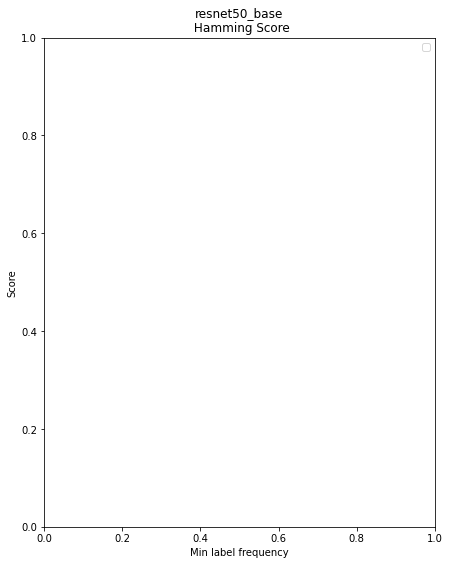

In [41]:
plot_results(MIN_FREQS,
             acc = list(exp_exact_match.values()),
             loss = list(exp_hloss.values()),
             score = list(exp_hscore.values()),
             label= list(exp_exact_match.keys()),
             title = data_flags,
            xlabel = "Min label frequency", ylabel = "Score")

# Best model at a given threshold

In [ ]:
result_dict = 
for m, hl in zip(exp_exact_match.keys(), exp_hscore.values()):
    print(m, hl)
    

In [ ]:
METHOD = "RakelD" # | "MLTSVM" | "BRkNN" | "CC" | "RakelD" | "LP" | "MLkNN" | "BR"
BASE_CLF = "SVC" # | "SVC" | "DT" | "GNB" | "LR"

top_labels, _= filter_labels(labels_train, number_labels = 25)
print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
X_train = features_train
Y_train = filter_dfs(labels_train, top_labels)
X_test = features_test_val
Y_test = filter_dfs(labels_test_val, top_labels)


clf = BASE_CLASSIFIERS[BASE_CLF]
if METHOD in ADAPT_METHODS.keys():
  met = ADAPT_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test)
else:
  met = TRANSF_METHODS[METHOD]
  clf_model, predictions = build_model(met, X_train, Y_train, X_test, Y_test, clf)

print("HAMMING SCORE: {}".format(clf_model['hamming_score']))
predictions = predictions.toarray()
present_labels = top_labels.index

cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

In [ ]:
# def plot_multiple_matrix(cfs_matrix, present_labels, nrows=5, ncols=5, figsize=(6,10), filename="results"):
plot_multiple_matrix(cfs_matrix, present_labels, figsize=(10, 10))

# Binary Relevance with handcrafted class balance

In [ ]:
def split_balanced(label, columns, X_train, Y_train):
  """Generates a balanced train and test dataset for a given label
    ATTENTION: MODIFIED TO ADD ONLY ORIGINAL PATTERNS TO THE NEGATIVE DATASET

    Parameters:
    label (String): label with which the balanced dataset will be created
    colnames (1D array):
    X_train, Y_train (dataFrames): original (potentially unbalanced) train datasets.

    Returns:
    X_train, Y_train (dataFrames): train datasets with equal number of positive and
                                  negative events for the given label. 

  """
  index_label = columns.tolist().index(label)
  indexes_positives = []
  indexes_negatives = []

  i=0
  for index, row in Y_train.iterrows():
    if row.values[index_label] == 1:
      indexes_positives.append(i)
    elif "_" not in index:
      indexes_negatives.append(i)
    i+=1
  indexes_negatives = indexes_negatives[0:len(indexes_positives)]
  final_indexes = indexes_positives + indexes_negatives
  final_indexes.sort()
  X_train = X_train.values[final_indexes, :]
  Y_train = Y_train.values[final_indexes, index_label]
  return X_train, Y_train

In [ ]:
base_classifiers = {}
THRESHOLD = 105
top_labels, _ = filter_labels(labels_train, THRESHOLD)
print("ATTENTION: TESTING WITH {} LABELS".format(len(top_labels)))
X_train = features_train
Y_train = filter_dfs(labels_train, top_labels)
X_test = features_test_val
Y_test = filter_dfs(labels_test_val, top_labels)
columns = Y_test.columns
predictions = []

for i in range(0, len(top_labels)):
  label = columns[i]
  bc = LogisticRegression(solver='lbfgs')
  X_train_label, Y_train_label = split_balanced(label, columns, X_train, Y_train) # tantos positivos como posible e igual a negativos
  bc.fit(X_train_label, Y_train_label)
  base_classifiers[label] = bc
  clf_prediction = bc.predict(X_test.values)
  predictions.append(clf_prediction) # una columna de prediccion

predictions = np.array(predictions).T

exact_match = accuracy_score(Y_test.values, predictions)
ham_loss = hamming_loss(Y_test.values, predictions)
ham_score = hamming_score(Y_test.values, predictions)

#print("Exact match ratio: {}".format(exact_match))
#print("Hamming loss: {}".format(ham_loss))
print("Hamming score: {}".format(ham_score))

In [ ]:
present_labels = top_labels.index
cfs_matrix = multilabel_confusion_matrix(Y_test, predictions)
class_report = classification_report(Y_test,
                                      predictions,
                                      output_dict=False,
                                      target_names=present_labels)
print(class_report)

In [ ]:
plot_multiple_matrix(cfs_matrix, present_labels,  figsize=(10, 10))